# PySpark MLlib Live Assignment

- The following assignment is based on [Machine Learning with PySpark and MLlib](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

## Data Loader

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

--2022-02-01 05:10:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

bank.zip            100%[===================>] 565.47K   871KB/s    in 0.6s    

2022-02-01 05:10:38 (871 KB/s) - ‘bank.zip’ saved [579043/579043]



In [2]:
# Unzipping the bank.csv
!unzip "bank.zip"

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


## Exploring The Data

- We will use the direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit. The dataset can be downloaded from [Kaggle](https://www.kaggle.com/rouseguy/bankbalanced/data).

In [6]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 25.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=324230e3a40c7812c1254b7384145eaa1fb872732b4b7b13cf96c01cb62e86a5
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank-full.csv', header = True, inferSchema = True, sep=';')
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome.
Output variable: deposit
Have a peek of the first five observations. Pandas data frame is prettier than Spark DataFrame.show().

In [8]:
import pandas as pd

pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


### Summary statistics for numeric variables

In [9]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,45211,40.93621021432837,10.618762040975408,18,95
balance,45211,1362.2720576850766,3044.7658291685243,-8019,102127
day,45211,15.80641879188693,8.322476153044596,1,31
duration,45211,258.1630797814691,257.52781226517095,0,4918
campaign,45211,2.763840658246887,3.098020883279184,1,63
pdays,45211,40.19782796222158,100.12874599059813,-1,871
previous,45211,0.5803233726305546,2.3034410449312204,0,275


### Correlations between independent variables.

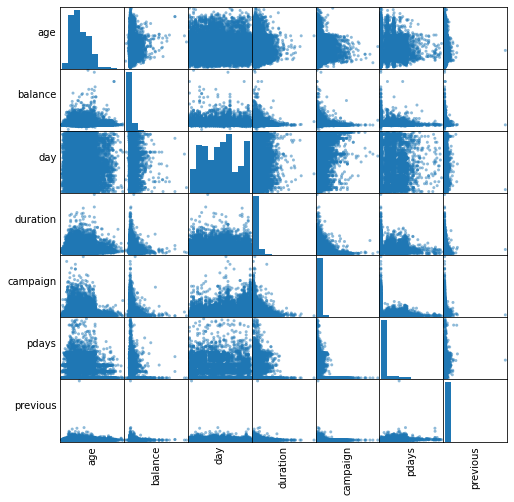

In [10]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

It’s obvious that there aren’t highly correlated numeric variables. Therefore, we will keep all of them for the model. However, day and month columns are not really useful, we will remove these two columns.

In [11]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



## Preparing Data for Machine Learning

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

In [13]:
from pyspark.ml.feature import OneHotEncoder , StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
### START CODE ###
# Use VectorAssembler and pass in assemblerInputs as inputCols and name the outputCol "features"
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
### END CODE ###
stages += [assembler]

The above code is taken from [databricks’ official site](https://docs.databricks.com/applications/machine-learning/train-model/mllib/index.html#binary-classification-example) and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

## Pipeline

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [14]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
### START CODE ###
# Fit the pipeline on df
pipelineModel = pipeline.fit(df)
# Transform pipelineModel on df
df = pipelineModel.transform(df)
### END CODE ###
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [15]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
features,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no


In [16]:
### START CODE ###
# Do a randomSplit with 0.7 and 0.3 with a seed 42
train, test = df.randomSplit([0.7, 0.3], seed=42)
### END CODE ###
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 31724
Test Dataset Count: 13487


## Logistic Regression Model

- You can build a RandomForestClassifier with : from pyspark.ml.classification import RandomForestClassifier
- You can build a Gradient-Boosted Tree Classifier with : from pyspark.ml.classification import GBTClassifier

In [17]:
from pyspark.ml.classification import LogisticRegression

### START CODE ###
# Fit a LogisticRegression with featuresCol as 'features', labelCol as 'label' and a maxIter of 10
lr = LogisticRegression(featuresCol='features', labelCol='label')
### END CODE ###
lrModel = lr.fit(train)

We can obtain the coefficients by using LogisticRegressionModel’s attributes.

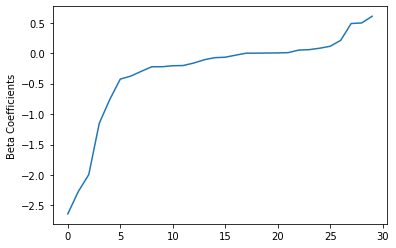

In [18]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

### Evaluate our Logistic Regression model.

In [19]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 24|blue-collar|  0.0|[3.20182496449895...|       0.0|[0.96090289611763...|
| 25|blue-collar|  0.0|[3.59411493585800...|       0.0|[0.97325021927962...|
| 26|blue-collar|  0.0|[3.38398158175481...|       0.0|[0.96720015220724...|
| 26|blue-collar|  0.0|[3.70652174572694...|       0.0|[0.97602605686266...|
| 27|blue-collar|  0.0|[3.03150958034900...|       0.0|[0.95397749567203...|
| 27|blue-collar|  0.0|[3.05425109164142...|       0.0|[0.95496570385700...|
| 27|blue-collar|  0.0|[2.56808864864823...|       0.0|[0.92877936693119...|
| 28|blue-collar|  0.0|[3.08136570209266...|       0.0|[0.95611752081026...|
| 28|blue-collar|  0.0|[2.82498565376713...|       0.0|[0.94401116268596...|
| 28|blue-collar|  0.0|[3.16795762865608...|       0.0|[0.95961050022821...|

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8918822918428977


## OPTIONAL: HyperParameter Tuning a Gradient-Boosted Tree Classifier

In [21]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 24|blue-collar|  0.0|[1.01607649304228...|       0.0|[0.88413181821178...|
| 25|blue-collar|  0.0|[1.13941921837144...|       0.0|[0.90710921741372...|
| 26|blue-collar|  0.0|[1.03934307933872...|       0.0|[0.88881426124118...|
| 26|blue-collar|  0.0|[1.22206241486438...|       0.0|[0.92013074800434...|
| 27|blue-collar|  0.0|[1.01400792600463...|       0.0|[0.88370732483409...|
| 27|blue-collar|  0.0|[1.01400792600463...|       0.0|[0.88370732483409...|
| 27|blue-collar|  0.0|[0.99440152776125...|       0.0|[0.87961644904353...|
| 28|blue-collar|  0.0|[1.03934307933872...|       0.0|[0.88881426124118...|
| 28|blue-collar|  0.0|[1.02212693872907...|       0.0|[0.88536571612542...|
| 28|blue-collar|  0.0|[1.03146395202988...|       0.0|[0.88724740809561...|

In [22]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.9023030355445915